In [1]:
import os
import numpy as np
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet152
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score

## Data Import

In [2]:
def load_images_from_folder(base_path,subpath):
    datasets = {'healthy': {'images': [], 'labels': []},
                'parkinson': {'images': [], 'labels': []}}
    
    for dataset in ['testing', 'training']:
        dataset_path = os.path.join(base_path, subpath, dataset)
        
        for class_label, class_folder in enumerate(['healthy', 'parkinson']):
            class_path = os.path.join(dataset_path, class_folder)
            
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    
                    try:
                        with Image.open(img_path) as img:
                            img = img.convert('RGB')
                            img = img.resize((224, 224))  # Adjust size as needed
                            img_array = np.array(img)
                            datasets[class_folder]['images'].append(img_array)
                            datasets[class_folder]['labels'].append(class_label)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    for dataset in datasets:
        datasets[dataset]['images'] = np.array(datasets[dataset]['images'])
        datasets[dataset]['labels'] = np.array(datasets[dataset]['labels'])
    
    return datasets


In [3]:
# Usage
base_path = 'D:\Projects\Parkinsons_disease\image_model_v2\data'
datasets_spiral = load_images_from_folder(base_path,'spiral')

# Access healthy and parkinson data separately
X_healthy_spiral, y_healthy_spiral = datasets_spiral['healthy']['images'], datasets_spiral['healthy']['labels']
X_parkinson_spiral, y_parkinson_spiral = datasets_spiral['parkinson']['images'], datasets_spiral['parkinson']['labels']

print(f"Loaded {len(X_healthy_spiral)} healthy images and {len(X_parkinson_spiral)} parkinson images of spiral")
print(f"Image shape: {X_healthy_spiral[0].shape}")
print(f"Number of classes: {len(np.unique(np.concatenate([y_healthy_spiral, y_parkinson_spiral])))}")

Loaded 51 healthy images and 51 parkinson images of spiral
Image shape: (224, 224, 3)
Number of classes: 2


In [4]:
# Usage
base_path = 'D:\Projects\Parkinsons_disease\image_model_v2\data'
datasets_spiral = load_images_from_folder(base_path,'wave')

# Access healthy and parkinson data separately
X_healthy_wave, y_healthy_wave = datasets_spiral['healthy']['images'], datasets_spiral['healthy']['labels']
X_parkinson_wave, y_parkinson_wave = datasets_spiral['parkinson']['images'], datasets_spiral['parkinson']['labels']

print(f"Loaded {len(X_healthy_wave)} healthy images and {len(X_parkinson_wave)} parkinson images of wave")
print(f"Image shape: {X_healthy_wave[0].shape}")
print(f"Number of classes: {len(np.unique(np.concatenate([y_healthy_wave, y_parkinson_wave])))}")

Loaded 51 healthy images and 51 parkinson images of wave
Image shape: (224, 224, 3)
Number of classes: 2


In [5]:
# Step 1: Concatenate the arrays by type
X_spiral = np.concatenate([X_healthy_spiral, X_parkinson_spiral])
y_spiral = np.concatenate([np.zeros(len(X_healthy_spiral)), np.ones(len(X_parkinson_spiral))])

X_wave = np.concatenate([X_healthy_wave, X_parkinson_wave])
y_wave = np.concatenate([np.zeros(len(X_healthy_wave)), np.ones(len(X_parkinson_wave))])

# Step 2: Split into train and test sets for spiral and wave
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(X_spiral, y_spiral, test_size=0.2, random_state=0)
X_wave_train, X_wave_test, y_wave_train, y_wave_test = train_test_split(X_wave, y_wave, test_size=0.2, random_state=0)

# Step 3: Separate the training data back into individual class arrays
X_train_spiral_healthy = X_spiral_train[y_spiral_train == 0]
X_train_spiral_parkinson = X_spiral_train[y_spiral_train == 1]

X_train_wave_healthy = X_wave_train[y_wave_train == 0]
X_train_wave_parkinson = X_wave_train[y_wave_train == 1]

### Spiral Healthy Resnet152 

In [6]:
spiral_healthy_model = ResNet152(weights='imagenet',include_top=False)
x = spiral_healthy_model.output
healthy_embedding = tf.keras.layers.Flatten()(x)
healthy_spiral_model = tf.keras.models.Model(inputs=spiral_healthy_model.input, outputs=healthy_embedding)
h_spiral_embed = healthy_spiral_model.predict(X_train_spiral_healthy)

2/2 [==============================] - 9s 929ms/step


In [7]:
np.save('D:\\Projects\\Parkinsons_disease\\image_model_v2\\embeddings\\healthy_embeddings_spiral.npy', h_spiral_embed)
healthy_spiral_model.save('D:\\Projects\\Parkinsons_disease\\image_model_v2\\embeddings\\healthy_model_spiral.h5')

### Spiral Parkinson Resnet152

In [8]:
spiral_parkinson_model = ResNet152(weights='imagenet',include_top=False)
x = spiral_parkinson_model.output
parkinson_embedding = tf.keras.layers.Flatten()(x)
parkinson_spiral_model = tf.keras.models.Model(inputs=spiral_parkinson_model.input, outputs=parkinson_embedding)
p_spiral_embed = parkinson_spiral_model.predict(X_train_spiral_parkinson)

2/2 [==============================] - 8s 977ms/step


In [9]:
np.save('D:\\Projects\\Parkinsons_disease\\image_model_v2\\embeddings\\parkinson_embeddings_spiral.npy', p_spiral_embed)
parkinson_spiral_model.save('D:\\Projects\\Parkinsons_disease\\image_model_v2\\embeddings\\parkinson_model_spiral.h5')

### Wave Healthy Resnet152

In [10]:
wave_healthy_model = ResNet152(weights='imagenet',include_top=False)
x = wave_healthy_model.output
healthy_embedding = tf.keras.layers.Flatten()(x)
healthy_wave_model = tf.keras.models.Model(inputs=wave_healthy_model.input, outputs=healthy_embedding)
h_wave_embed = healthy_wave_model.predict(X_train_wave_healthy)

2/2 [==============================] - 9s 1s/step


In [11]:
np.save('D:\\Projects\\Parkinsons_disease\\image_model_v2\\embeddings\\healthy_embeddings_wave.npy', h_wave_embed)
healthy_wave_model.save('D:\\Projects\\Parkinsons_disease\\image_model_v2\\embeddings\\healthy_model_wave.h5')

### Wave Parkinson Resnet152

In [12]:
wave_parkinson_model = ResNet152(weights='imagenet',include_top=False)
x = wave_parkinson_model.output
parkinson_embedding = tf.keras.layers.Flatten()(x)
parkinson_wave_model = tf.keras.models.Model(inputs=wave_parkinson_model.input, outputs=parkinson_embedding)
p_wave_embed = parkinson_wave_model.predict(X_train_wave_parkinson)

2/2 [==============================] - 8s 952ms/step


In [13]:
np.save('D:\\Projects\\Parkinsons_disease\\image_model_v2\\embeddings\\parkinson_embeddings_wave.npy', p_wave_embed)
parkinson_wave_model.save('D:\\Projects\\Parkinsons_disease\\image_model_v2\\embeddings\\parkinson_model_wave.h5')

In [14]:
def classify_images(wave_array,spiral_array):
    embeddings_A_spiral = np.load('D:\Projects\Parkinsons_disease\image_model_v2\embeddings\healthy_embeddings_spiral.npy')
    embeddings_B_spiral = np.load('D:\Projects\Parkinsons_disease\image_model_v2\embeddings\parkinson_embeddings_spiral.npy')
    embeddings_A_wave = np.load('D:\Projects\Parkinsons_disease\image_model_v2\embeddings\healthy_embeddings_wave.npy')
    embeddings_B_wave = np.load('D:\Projects\Parkinsons_disease\image_model_v2\embeddings\parkinson_embeddings_wave.npy')

    parkinson_spiral_model = tf.keras.models.load_model('D:\Projects\Parkinsons_disease\image_model_v2\embeddings\parkinson_model_spiral.h5')
    healthy_spiral_model = tf.keras.models.load_model('D:\Projects\Parkinsons_disease\image_model_v2\embeddings\healthy_model_spiral.h5')
    parkinson_wave_model = tf.keras.models.load_model('D:\Projects\Parkinsons_disease\image_model_v2\embeddings\parkinson_model_wave.h5')
    healthy_wave_model = tf.keras.models.load_model('D:\Projects\Parkinsons_disease\image_model_v2\embeddings\healthy_model_wave.h5')
    class_confidence = []

    for i in range(wave_array.shape[0]):
        temp = []
        wave_preds_h = healthy_wave_model.predict(np.expand_dims(wave_array[i], axis=0))
        wave_preds_p = parkinson_wave_model.predict(np.expand_dims(wave_array[i], axis=0))
        spiral_preds_h = healthy_spiral_model.predict(np.expand_dims(spiral_array[i], axis=0))
        spiral_preds_p = parkinson_spiral_model.predict(np.expand_dims(spiral_array[i], axis=0))
    
        # Compute similarity scores fior wave
        sim_A = np.max(cosine_similarity(wave_preds_h, embeddings_A_wave))
        sim_B = np.max(cosine_similarity(wave_preds_p, embeddings_B_wave))
        if sim_A > sim_B:
            temp.append(abs(1-((sim_A+1)/2)))
        else:
            temp.append(((sim_B+1)/2))
        
        # Compute similarity scores fior spiral
        sim_A = np.max(cosine_similarity(spiral_preds_h,embeddings_A_spiral))
        sim_B = np.max(cosine_similarity(spiral_preds_p, embeddings_B_spiral))
        if sim_A > sim_B:
            temp.append(abs(1-((sim_A+1)/2)))
        else:
            temp.append(((sim_B+1)/2))
        
        class_confidence.append(temp)
    return class_confidence

In [15]:
conf = classify_images(X_wave_test,X_spiral_test)

1/1 [==============================] - 0s 264ms/step


In [16]:
conf

[[0.08480048179626465, 0.07035380601882935],
 [0.8597229719161987, 0.14428487420082092],
 [0.10309603810310364, 0.9060624837875366],
 [0.8980645835399628, 0.9057800769805908],
 [0.10419777035713196, 0.08155936002731323],
 [0.8999477922916412, 0.941735178232193],
 [0.12187612056732178, 0.09777241945266724],
 [0.11731889843940735, 0.9430963397026062],
 [0.8818644881248474, 0.8757441341876984],
 [0.911406934261322, 0.08297878503799438],
 [0.9290332198143005, 0.893962949514389],
 [0.8734197914600372, 0.14212077856063843],
 [0.9167165160179138, 0.8849819004535675],
 [0.10682070255279541, 0.02975296974182129],
 [0.11194175481796265, 0.05640628933906555],
 [0.12806367874145508, 0.042373061180114746],
 [0.08833274245262146, 0.04715079069137573],
 [0.14207294583320618, 0.053564608097076416],
 [0.08701467514038086, 0.0301627516746521],
 [0.08971166610717773, 0.09638708829879761],
 [0.11983191967010498, 0.0376187264919281]]

In [17]:
a = pd.DataFrame(conf,columns=["wave_preds","spiral_preds",])

In [18]:
b = pd.DataFrame(y_wave_test,columns=['true_label'])

In [19]:
final = pd.concat([a,b],axis=1)

In [20]:
df = final.copy()  # Create a copy to avoid modifying the original DataFrame
df['wave_preds_bool'] = (df['wave_preds'] > 0.5).astype(int)
df['spiral_preds_bool'] = (df['spiral_preds'] > 0.5).astype(int)

# Step 2: Create the 'prediction' column based on the condition
df['prediction_AND'] = ((df['wave_preds_bool'] == 1) & (df['spiral_preds_bool'] == 1)).astype(int)
df['prediction_OR'] = ((df['wave_preds_bool'] == 1) | (df['spiral_preds_bool'] == 1)).astype(int)
df['true_label'] = (df['true_label']).astype(int)

# Considering Wave Model Embedding Based Only

In [44]:
# Iterate over the DataFrame to calculate TP, TN, FP, FN
TP = 0  # True Positives
TN = 0  # True Negatives
FP = 0  # False Positives
FN = 0  # False Negatives

for true, pred in zip(df['true_label'], df['wave_preds_bool']):
    if true == 1 and pred == 1:
        TP += 1  # True Positive
    elif true == 0 and pred == 0:
        TN += 1  # True Negative
    elif true == 0 and pred == 1:
        FP += 1  # False Positive
    elif true == 1 and pred == 0:
        FN += 1  # False Negative

print(f'True Positives (TP): {TP}')
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')


True Positives (TP): 8
True Negatives (TN): 11
False Positives (FP): 0
False Negatives (FN): 2


In [45]:
print(f"Accuracy is {(TP + TN) / (TP + FP + TN + FN)}")
# Precision: TP / (TP + FP)
print(f"Precision is {TP / (TP + FP)}")
# Recall: TP / (TP + FN)
print(f"Recall is {TP / (TP + FN)}")
# F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score is {f1}")

Accuracy is 0.9047619047619048
Precision is 1.0
Recall is 0.8
F1 Score is 0.888888888888889


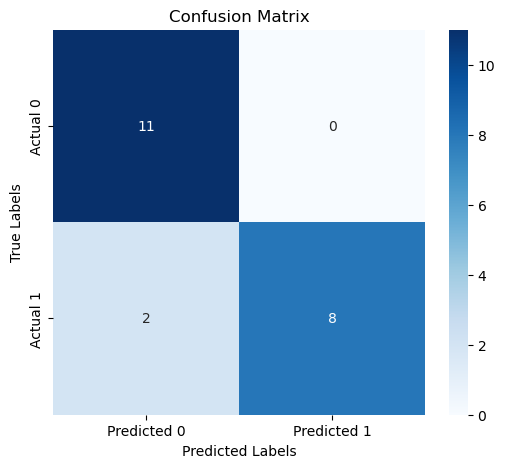

In [46]:
# Confusion matrix values
conf_matrix = [[TN, FP], [FN, TP]]

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Considering Spiral Model Embedding Only

In [47]:
# Iterate over the DataFrame to calculate TP, TN, FP, FN
TP = 0  # True Positives
TN = 0  # True Negatives
FP = 0  # False Positives
FN = 0  # False Negatives

for true, pred in zip(df['true_label'], df['spiral_preds_bool']):
    if true == 1 and pred == 1:
        TP += 1  # True Positive
    elif true == 0 and pred == 0:
        TN += 1  # True Negative
    elif true == 0 and pred == 1:
        FP += 1  # False Positive
    elif true == 1 and pred == 0:
        FN += 1  # False Negative

print(f'True Positives (TP): {TP}')
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')


True Positives (TP): 6
True Negatives (TN): 10
False Positives (FP): 1
False Negatives (FN): 4


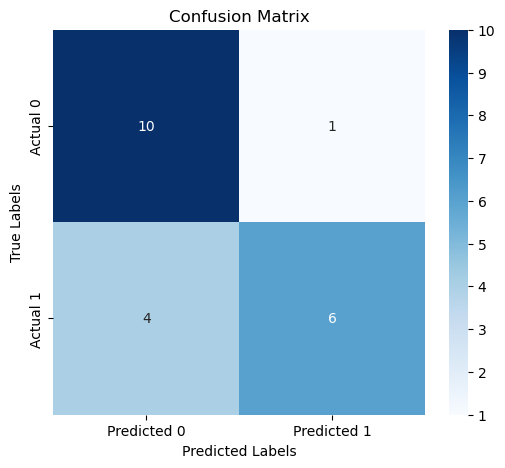

In [48]:
# Confusion matrix values
conf_matrix = [[TN, FP], [FN, TP]]

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [49]:
print(f"Accuracy is {(TP + TN) / (TP + FP + TN + FN)}")
# Precision: TP / (TP + FP)
print(f"Precision is {TP / (TP + FP)}")
# Recall: TP / (TP + FN)
print(f"Recall is {TP / (TP + FN)}")
# F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score is {f1}")

Accuracy is 0.7619047619047619
Precision is 0.8571428571428571
Recall is 0.6
F1 Score is 0.7058823529411764


# Considering Both Models Predictions

In [50]:
# Iterate over the DataFrame to calculate TP, TN, FP, FN
TP = 0  # True Positives
TN = 0  # True Negatives
FP = 0  # False Positives
FN = 0  # False Negatives

for true, pred in zip(df['true_label'], df['prediction_AND']):
    if true == 1 and pred == 1:
        TP += 1  # True Positive
    elif true == 0 and pred == 0:
        TN += 1  # True Negative
    elif true == 0 and pred == 1:
        FP += 1  # False Positive
    elif true == 1 and pred == 0:
        FN += 1  # False Negative

print(f'True Positives (TP): {TP}')
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')


True Positives (TP): 5
True Negatives (TN): 11
False Positives (FP): 0
False Negatives (FN): 5


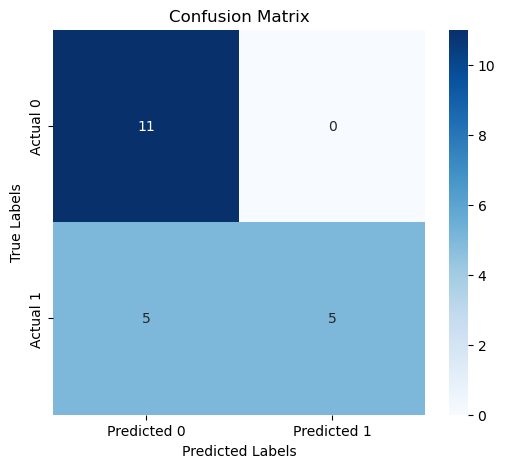

In [51]:
# Confusion matrix values
conf_matrix = [[TN, FP], [FN, TP]]

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [52]:
print(f"Accuracy is {(TP + TN) / (TP + FP + TN + FN)}")
# Precision: TP / (TP + FP)
print(f"Precision is {TP / (TP + FP)}")
# Recall: TP / (TP + FN)
print(f"Recall is {TP / (TP + FN)}")
# F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score is {f1}")

Accuracy is 0.7619047619047619
Precision is 1.0
Recall is 0.5
F1 Score is 0.6666666666666666


# Considering Any One Model's Predictions

In [53]:
# Iterate over the DataFrame to calculate TP, TN, FP, FN
TP = 0  # True Positives
TN = 0  # True Negatives
FP = 0  # False Positives
FN = 0  # False Negatives

for true, pred in zip(df['true_label'], df['prediction_OR']):
    if true == 1 and pred == 1:
        TP += 1  # True Positive
    elif true == 0 and pred == 0:
        TN += 1  # True Negative
    elif true == 0 and pred == 1:
        FP += 1  # False Positive
    elif true == 1 and pred == 0:
        FN += 1  # False Negative

print(f'True Positives (TP): {TP}')
print(f'True Negatives (TN): {TN}')
print(f'False Positives (FP): {FP}')
print(f'False Negatives (FN): {FN}')


True Positives (TP): 9
True Negatives (TN): 10
False Positives (FP): 1
False Negatives (FN): 1


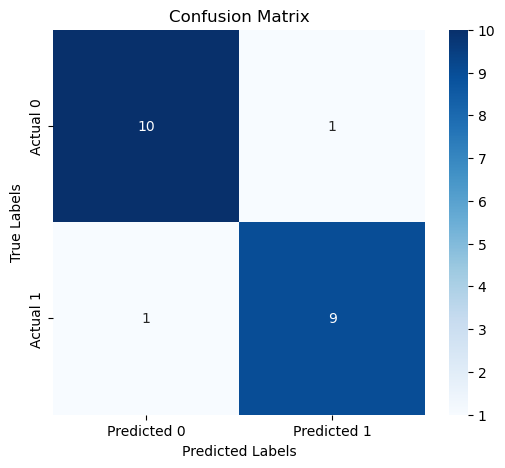

In [54]:
# Confusion matrix values
conf_matrix = [[TN, FP], [FN, TP]]

# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [55]:
print(f"Accuracy is {(TP + TN) / (TP + FP + TN + FN)}")
# Precision: TP / (TP + FP)
print(f"Precision is {TP / (TP + FP)}")
# Recall: TP / (TP + FN)
print(f"Recall is {TP / (TP + FN)}")
# F1 Score: 2 * (Precision * Recall) / (Precision + Recall)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print(f"F1 Score is {f1}")

Accuracy is 0.9047619047619048
Precision is 0.9
Recall is 0.9
F1 Score is 0.9


In [56]:
X = df.drop(columns=['spiral_preds_bool','wave_preds_bool','true_label','prediction_AND','prediction_OR'],axis=1)
y= df['true_label']

In [57]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=0)

In [31]:
xtrain.shape

(14, 2)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC Score: 1.0


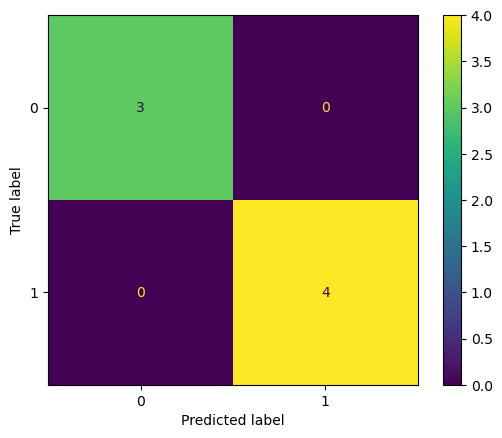

In [32]:
svc = SVC()
svc.fit(xtrain,ytrain)
svcPreds = svc.predict(xtest)
print(f"Accuracy: {accuracy_score(ytest,svcPreds)}")
print(f"Precision: {precision_score(ytest,svcPreds)}")
print(f"Recall: {recall_score(ytest,svcPreds)}")
print(f"F1 Score: {f1_score(ytest,svcPreds)}")
print(f"ROC Score: {roc_auc_score(ytest,svcPreds)}")
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(svcPreds,ytest)).plot()


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC Score: 1.0


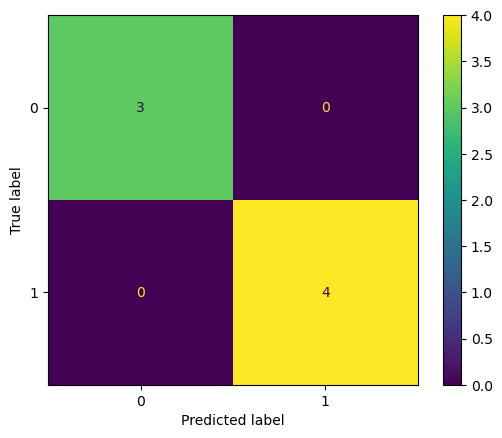

In [33]:
log = LogisticRegression()
log.fit(xtrain,ytrain)
logPreds = log.predict(xtest)
print(f"Accuracy: {accuracy_score(ytest,logPreds)}")
print(f"Precision: {precision_score(ytest,logPreds)}")
print(f"Recall: {recall_score(ytest,logPreds)}")
print(f"F1 Score: {f1_score(ytest,logPreds)}")
print(f"ROC Score: {roc_auc_score(ytest,logPreds)}")
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(logPreds,ytest)).plot()

Accuracy: 0.7142857142857143
Precision: 1.0
Recall: 0.5
F1 Score: 0.6666666666666666
ROC Score: 0.75


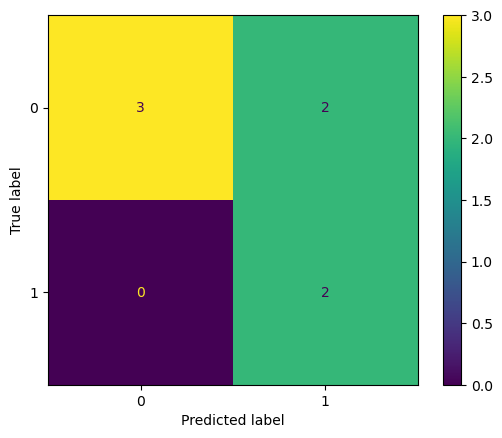

In [34]:
knn = KNeighborsClassifier()
knn.fit(xtrain,ytrain)
knnPreds = knn.predict(xtest)
print(f"Accuracy: {accuracy_score(ytest,knnPreds)}")
print(f"Precision: {precision_score(ytest,knnPreds)}")
print(f"Recall: {recall_score(ytest,knnPreds)}")
print(f"F1 Score: {f1_score(ytest,knnPreds)}")
print(f"ROC Score: {roc_auc_score(ytest,knnPreds)}")
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(knnPreds,ytest)).plot()